<a href="https://colab.research.google.com/github/glorivaas/Machine_Learning25/blob/main/Lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 7 - Gradient Boosting

### Author: Gloria Rivas

1. **Derivation and Analysis**

  **Scenario A:**
  - Derive explicitly the optimal $\lambda$ for fitting from scratch, i.e., solve
    
    $$
    \lambda^* = \arg\min_{\lambda} \sum_{i=1}^{n} L(y_i, \lambda)
    $$
  <br>Where the loss is:
  $$
L(y_i, \lambda) = -y_i \log(\sigma(\lambda)) - (1 - y_i) \log(1 - \sigma(\lambda))
$$

with the sigmoid function:

$$
\sigma(\lambda) = \frac{1}{1 + e^{-\lambda}}
$$

Let:
- $ m $: number of samples where $ y_i = 1 $
- $ k $: number of samples where $ y_i = 0 $
- $ n = m + k $

Then the total loss becomes:

$$
\mathcal{L}(\lambda) = -m \log(\sigma(\lambda)) - k \log(1 - \sigma(\lambda))
$$

Take the derivative with respect to $ \lambda $:

$$
\frac{d\mathcal{L}}{d\lambda} = \sigma(\lambda)(1 - \sigma(\lambda)) \left( -\frac{m}{\sigma(\lambda)} + \frac{k}{1 - \sigma(\lambda)} \right)
$$

Simplify:

$$
= -m (1 - \sigma(\lambda)) + k \sigma(\lambda)
$$

Set derivative to zero:

$$
-m + m \sigma(\lambda) + k \sigma(\lambda) = 0
\Rightarrow \sigma(\lambda)(m + k) = m
\Rightarrow \sigma(\lambda) = \frac{m}{m + k} = \frac{m}{n}
$$

Solve for $ \lambda $:

$$
\sigma(\lambda) = \frac{1}{1 + e^{-\lambda}} = \frac{m}{n}
\Rightarrow \lambda^* = \log\left( \frac{m}{k} \right)
$$

---
Final Result

$$
\boxed{\lambda^* = \log\left( \frac{m}{k} \right)}
$$

---
**Interpretation**

- The optimal constant $ \lambda^* $ reflects the log-odds of the class distribution.
- If $ m = k $, then $ \lambda^* = 0 $ (neutral prediction).
- If $ m > k $, then $ \lambda^* > 0 $ : model favors class 1.
- If $ m < k $, then $ \lambda^* < 0 $ : model favors class 0.

### Scenario B

Now assume that we already have predictions $ f_i = f_{m-1}(x_i) $, and we want to add a constant shift $ \lambda $:

$$
\lambda^* = \arg\min_{\lambda} \sum_{i=1}^n L(y_i, f_i + \lambda)
$$

Where:

$$
L(y_i, f_i + \lambda) = -y_i \log(\sigma(f_i + \lambda)) - (1 - y_i) \log(1 - \sigma(f_i + \lambda))
$$

Let $ s_i = \sigma(f_i + \lambda) $, then:

$$
\frac{d\mathcal{L}}{d\lambda} = \sum_{i=1}^n \left( s_i - y_i \right)
= \sum_{i=1}^n \left( \sigma(f_i + \lambda) - y_i \right)
$$

Set derivative to zero:

$$
\boxed{
\sum_{i=1}^{n} \left[ \sigma(f_i + \lambda) - y_i \right] = 0
}
$$

---

- In Scenario A, all predictions are constant. The optimization is simple and convex.
- In Scenario B:
  - Each $ f_i $ is different.
  - The sigmoid is applied to $ f_i + \lambda $, making the loss **nonlinear** and **non-separable**.
  - The result is a **complex loss landscape** with **no closed-form** for $ \lambda $.
  - Must be solved **numerically** (e.g., gradient descent).

The difficulty arises from the interaction between the **non-linearity of the sigmoid function** and the **variability in the previous predictions**.

2. **Loss Landscape Exploration (Python)**

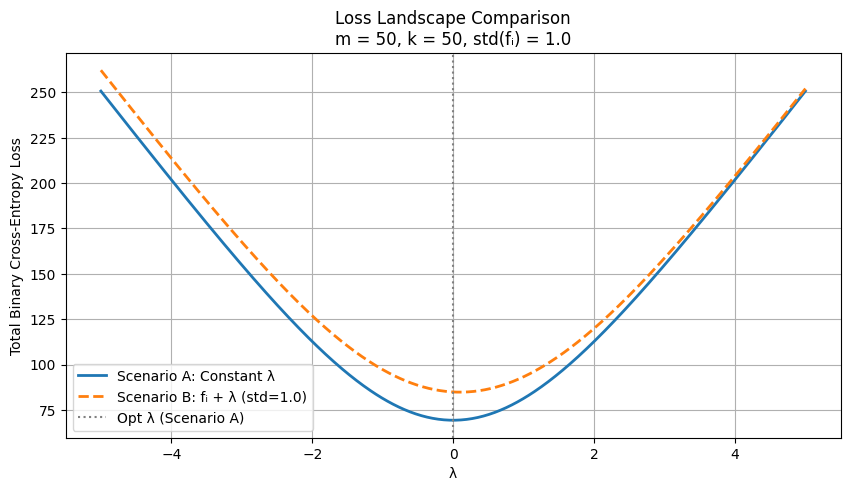

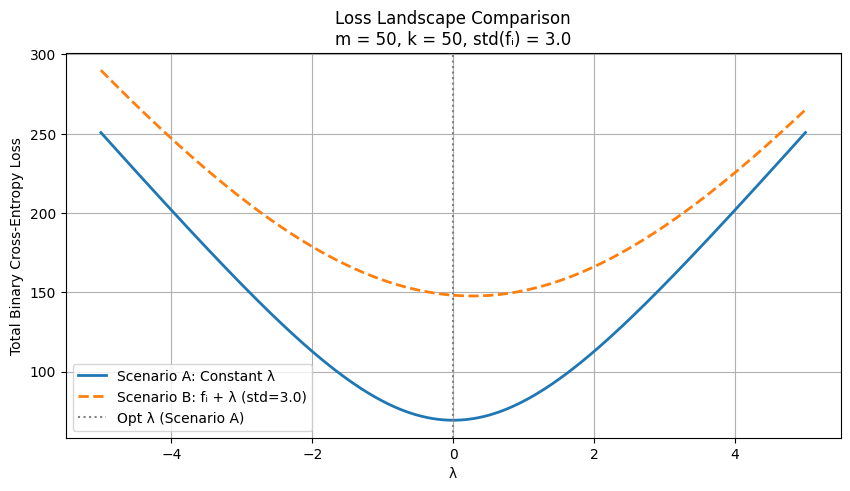

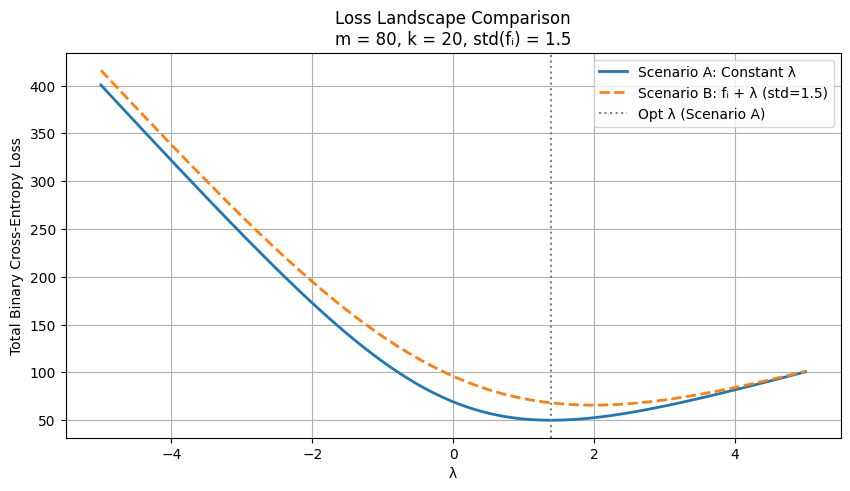

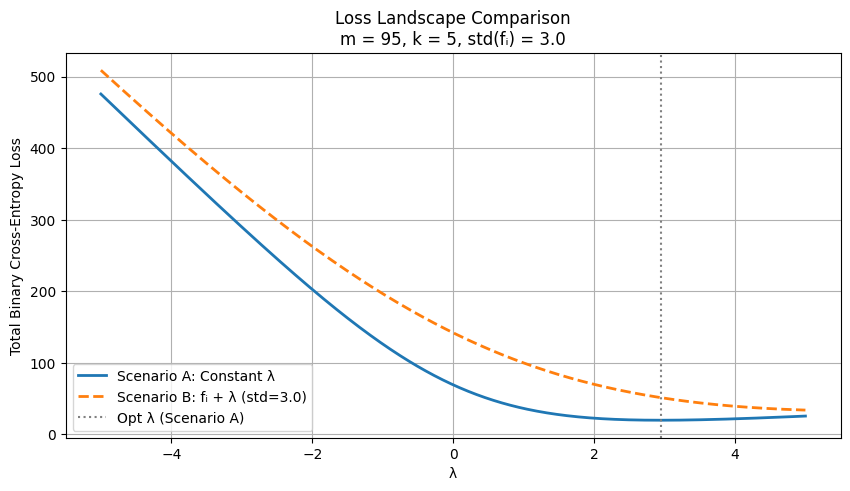

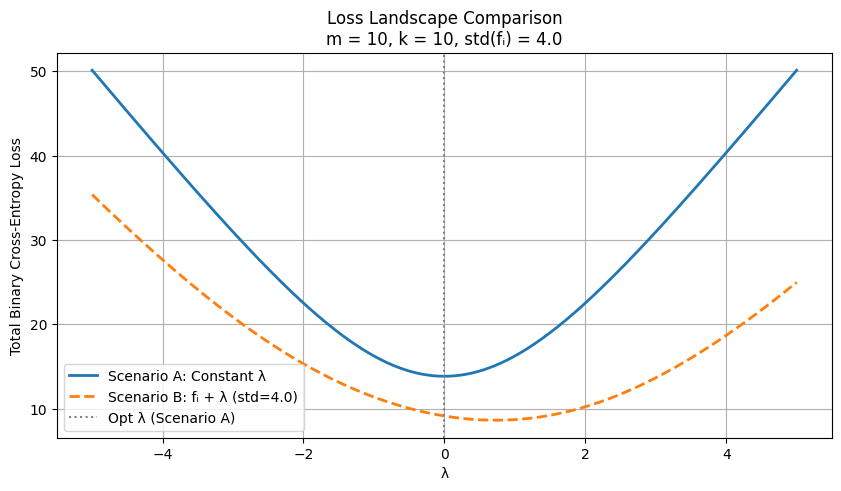

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

def binary_cross_entropy(y, z):
    """Binary cross-entropy loss"""
    sig = expit(z)
    return -y * np.log(sig + 1e-15) - (1 - y) * np.log(1 - sig + 1e-15)

def run_loss_landscape_experiment(m, k, std_fi, n_points=500):
    n = m + k
    y = np.array([1]*m + [0]*k)
    np.random.seed(42)
    f = np.random.normal(loc=0.0, scale=std_fi, size=n)

    lambda_vals = np.linspace(-5, 5, n_points)

    loss_a = [np.sum(binary_cross_entropy(y, np.full(n, lam))) for lam in lambda_vals]

    loss_b = [np.sum(binary_cross_entropy(y, f + lam)) for lam in lambda_vals]

    plt.figure(figsize=(10, 5))
    plt.plot(lambda_vals, loss_a, label="Scenario A: Constant λ", linewidth=2)
    plt.plot(lambda_vals, loss_b, label=f"Scenario B: fᵢ + λ (std={std_fi})", linewidth=2, linestyle='--')
    plt.title(f"Loss Landscape Comparison\nm = {m}, k = {k}, std(fᵢ) = {std_fi}")
    plt.xlabel("λ")
    plt.ylabel("Total Binary Cross-Entropy Loss")
    opt_lambda = np.log(m / k)
    plt.axvline(opt_lambda, color='gray', linestyle=':', label='Opt λ (Scenario A)')

    plt.grid(True)
    plt.legend()
    plt.show()



run_loss_landscape_experiment(m=50, k=50, std_fi=1.0)

run_loss_landscape_experiment(m=50, k=50, std_fi=3.0)

run_loss_landscape_experiment(m=80, k=20, std_fi=1.5)

run_loss_landscape_experiment(m=95, k=5, std_fi=3.0)

run_loss_landscape_experiment(m=10, k=10, std_fi=4.0)


Let's answer the **research questions**:

1. **Why is finding an optimal additive shift  λ  in the forward stagewise procedure fundamentally harder than directly fitting a single-parameter predictor from scratch?**

 In Scenario A, all predictions are a constant value $ \lambda $. The binary cross-entropy loss simplifies to a convex, smooth function that depends only on the distribution of labels (number of 0s and 1s). This allows for a closed-form solution:

 $$
\lambda^* = \log\left( \frac{m}{k} \right)
$$

 where $ m $ and $ k $ are the counts of labels 1 and 0 respectively.

 In Scenario B, we already have predictions $f_i $, and we apply the same additive shift $ \lambda $ to each one:

 $$
L(y_i, f_i + \lambda)
$$

 This results in a sum of non-linear terms, each involving a different  $f_i $. The optimization problem becomes:

 $$
\sum_{i=1}^{n} \left[ \sigma(f_i + \lambda) - y_i \right] = 0
$$

 This equation cannot be solved analytically, because:
- Each term depends on a different input $ f_i $
- The sigmoid function introduces non-linearity
- The loss function becomes more complex and dataset-dependent

 Hence, finding the optimal $ \lambda \$ requires numerical methods such as gradient descent.

---
2. **How does the complexity of the loss landscape differ between these two scenarios?**

 In Scenario A:
 - The loss landscape is **simple**, **symmetric**, and **unimodal**
 - Easy to visualize and optimize

 In Scenario B:
 - The loss landscape is still smooth and usually **unimodal**, but more **complex**
 - Shape is influenced by the distribution of $ f_i $ and the class imbalance between positive and negative samples
 - Can be **asymmetric**, skewed, **non-intuitive**, and computationally expensive to optimize

###Discussion: Comparing Loss Landscapes in Scenario A vs. Scenario B
- Can the minimizer be found numerically?

  Yes, even though there is **no closed-form solution**, the loss in Scenario B is still:

 - Differentiable
 - Convex (in most practical cases)

 So it's easy to optimize using numerical methods like:

 - Gradient descent
 - Line search
 - Newton's method

- Where does the difficulty come from?

  The complexity in Scenario B comes from:

  - The **non-linearity** of the sigmoid function
  - The **variability** in the predictions $f_i$

 In conclusion, it is not because the loss is multimodal or chaotic, it is just because it is harder to express algebraically, so we can say that the difficulty in Scenario B comes from the non-linearity of the problem. Therefore, Scenario A is easier to analyze and optimize, but Scenario B is still very usable, it is just that we need a numerical solver.
